In [ ]:
###
###
###    This notebook predicts three digits: next day prices based on the day ahead market info ++, 
###
###    Input: 
###     battery discharging time -- time during which we can sell electricity (based on the C factor)
###     hours in advance we need to predict the prices
###
###    Output: 
###     1. per MW price on RTM (if we know the prices in advance)
###     2. per MW price if we use DAM price info
###     3. per MW price if we use our prediction
###     4. 5-minutes shedule of RTM prices during given time slot (the latter is given as an input)
###   
###    Abbreviation:
###     DAM -- day ahead market
###     LMP -- location marginal prices
###     MDP -- Markov Decision Processes
###     RL  -- Reinforcement Learning
###     RTM -- real time market
###     
###
###   Tutorials: 
###     https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
###
###
###

In [ ]:
## battery discharge time in timeslots
## 
battery_discharge = [12, 24, 36, 48, 60]

In [ ]:
## User input

# Start date for the analysis
date_start = '2021-04-01'

# Days (interval: date_start to date_start + days)
days = 100

# Directory for datasets
root_path = '/content/gdrive/My Drive/Consulting/2022 ZeroAvia (Maximov, Consulting)/Datasets/'

In [ ]:
## Import and install necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

## Data science libraries
!pip install statsmodels
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import load_boston

## deep learning 
from tensorflow import keras
from tensorflow.keras import layers

##from statsmodels.tsa.arima.model import ARIMA

from google.colab import auth 
auth.authenticate_user()

## Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

## suspend warnings for demo purposes
import warnings
warnings.filterwarnings("ignore")

#pd.set_option('display.max_columns', None)


## random seeds for hyperparameter fitting 
import random
from itertools import product

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
## Upload pricing information for both RTM and DAM markets
DAM_price = pd.read_csv(root_path+'HOLLISTR_1_N101_DAM.csv')
RTM_price = pd.read_csv(root_path+'HOLLISTR_1_N101.csv')

## filter all by LMP -- location marginal prices only
## NB: a correct price is a sum over all, not LMP only

#RTM_price = RTM_price[RTM_price['LMP_TYPE'] == 'LMP'] 
#DAM_price = DAM_price[DAM_price['LMP_TYPE'] == 'LMP'] 

## print what we have
print(RTM_price.head())
print(DAM_price.head())


## NB: Notice, that the OPR_DR+OPR_HR+OPR_INTERVAL does not match to the time difference of the UTC timestamp (8 hours vs 7 hours)

       INTERVALSTARTTIME_GMT        INTERVALENDTIME_GMT      OPR_DT  OPR_HR  \
0  2021-04-01T00:00:00-00:00  2021-04-01T00:05:00-00:00  2021-03-31      18   
1  2021-04-01T00:05:00-00:00  2021-04-01T00:10:00-00:00  2021-03-31      18   
2  2021-04-01T00:10:00-00:00  2021-04-01T00:15:00-00:00  2021-03-31      18   
3  2021-04-01T00:15:00-00:00  2021-04-01T00:20:00-00:00  2021-03-31      18   
4  2021-04-01T00:20:00-00:00  2021-04-01T00:25:00-00:00  2021-03-31      18   

       NODE_ID_XML          NODE_ID             NODE MARKET_RUN_ID LMP_TYPE  \
0  HOLLISTR_1_N101  HOLLISTR_1_N101  HOLLISTR_1_N101           RTM      MCC   
1  HOLLISTR_1_N101  HOLLISTR_1_N101  HOLLISTR_1_N101           RTM      MCC   
2  HOLLISTR_1_N101  HOLLISTR_1_N101  HOLLISTR_1_N101           RTM      MCC   
3  HOLLISTR_1_N101  HOLLISTR_1_N101  HOLLISTR_1_N101           RTM      MCC   
4  HOLLISTR_1_N101  HOLLISTR_1_N101  HOLLISTR_1_N101           RTM      MCC   

  XML_DATA_ITEM    PNODE_RESMRID GRP_TYPE  POS   M

In [ ]:
## drop extra columns 
RTM_price.drop(RTM_price.columns.difference(['OPR_DT', 'OPR_HR', 'OPR_INTERVAL', 'MW']), 1, inplace=True)
DAM_price.drop(DAM_price.columns.difference(['OPR_DT', 'OPR_HR', 'MW']), 1, inplace=True)


print(RTM_price)
print(DAM_price)

            OPR_DT  OPR_HR         MW  OPR_INTERVAL
0       2021-03-31      18    0.00000             1
1       2021-03-31      18    0.00000             2
2       2021-03-31      18    0.00000             3
3       2021-03-31      18    0.00000             4
4       2021-03-31      18    0.00000             5
...            ...     ...        ...           ...
115195  2021-07-09      17  280.18106             8
115196  2021-07-09      17  227.54270             9
115197  2021-07-09      17  160.68120            10
115198  2021-07-09      17  275.12814            11
115199  2021-07-09      17  665.18120            12

[115200 rows x 4 columns]
           OPR_DT  OPR_HR        MW
0      2021-03-31      22  52.80580
1      2021-03-31      19  59.93296
2      2021-03-31      20  89.20413
3      2021-03-31      23  44.18685
4      2021-03-31      21  66.06786
...           ...     ...       ...
11995  2021-07-09      17   0.00000
11996  2021-07-09       1   0.00000
11997  2021-07-09       3

In [ ]:
## Convert RTM in 5 mins schedule

# TODO: more efficient way?
RTM_price['OPR_DT'] = RTM_price['OPR_DT'].astype(str) + ' ' + (RTM_price['OPR_HR'] -1).astype(str) + ':' + (5*RTM_price['OPR_INTERVAL'] -5).astype(str)
RTM_price['OPR_DT'] = pd.to_datetime(RTM_price['OPR_DT'], format='%Y-%m-%d %H:%M')
RTM_price['OPR_DT'] = RTM_price['OPR_DT'] + pd.Timedelta(7, unit="h")
RTM_price.drop(RTM_price.columns.difference(['OPR_DT', 'MW']), 1, inplace=True)
RTM_price = RTM_price.groupby(['OPR_DT']).sum()
print(RTM_price)

                             MW
OPR_DT                         
2021-04-01 00:00:00     0.02090
2021-04-01 00:05:00     0.02085
2021-04-01 00:10:00     8.83622
2021-04-01 00:15:00    33.83907
2021-04-01 00:20:00    36.56618
...                         ...
2021-07-09 23:35:00   560.36212
2021-07-09 23:40:00   455.08539
2021-07-09 23:45:00   321.36240
2021-07-09 23:50:00   550.25627
2021-07-09 23:55:00  1330.36240

[28800 rows x 1 columns]


In [ ]:
## reset index for operational convenience
RTM_price = RTM_price.reset_index()
print(RTM_price)

                   OPR_DT          MW
0     2021-04-01 00:00:00     0.02090
1     2021-04-01 00:05:00     0.02085
2     2021-04-01 00:10:00     8.83622
3     2021-04-01 00:15:00    33.83907
4     2021-04-01 00:20:00    36.56618
...                   ...         ...
28795 2021-07-09 23:35:00   560.36212
28796 2021-07-09 23:40:00   455.08539
28797 2021-07-09 23:45:00   321.36240
28798 2021-07-09 23:50:00   550.25627
28799 2021-07-09 23:55:00  1330.36240

[28800 rows x 2 columns]


In [ ]:
## Convert DAM in 5 mins schedule
DAM_price['OPR_DT'] = DAM_price['OPR_DT'].astype(str) + ' ' + (DAM_price['OPR_HR'] -1).astype(str)+':00'
DAM_price['OPR_DT'] = pd.to_datetime(DAM_price['OPR_DT'], format='%Y-%m-%d %H:%M')

# time shift SFO - Greenwich + 1
DAM_price['OPR_DT'] = DAM_price['OPR_DT'] + pd.Timedelta(7, unit="h")
DAM_price = DAM_price.sort_values('OPR_DT', ascending=True)
DAM_price = DAM_price.groupby(['OPR_DT']).sum()
DAM_price = DAM_price.reset_index()

## add one more row at the end for correct scheduling (otherwise the last hour will not be splitted)
row = DAM_price.iloc[-1]
row['OPR_DT'] = row['OPR_DT'] + pd.Timedelta(1, unit="h")
DAM_price = DAM_price.append(row, ignore_index = False)


## return index to date-time
DAM_price['OPR_DT'] = pd.to_datetime(DAM_price['OPR_DT'])
DAM_price = DAM_price[['OPR_DT','MW']]
DAM_price.set_index('OPR_DT', inplace=True)

## split into 5 mins intervals
DAM_price = DAM_price.resample('5T').asfreq()

## fill NANs in the schedule
DAM_price.fillna(method='ffill', inplace=True)
DAM_price.drop(DAM_price.tail(1).index,inplace=True)

# reset index for RTM/DAM compatibility
DAM_price = DAM_price.reset_index()

print(DAM_price)



                   OPR_DT         MW
0     2021-04-01 00:00:00   76.59346
1     2021-04-01 00:05:00   76.59346
2     2021-04-01 00:10:00   76.59346
3     2021-04-01 00:15:00   76.59346
4     2021-04-01 00:20:00   76.59346
...                   ...        ...
28795 2021-07-09 23:35:00  168.94492
28796 2021-07-09 23:40:00  168.94492
28797 2021-07-09 23:45:00  168.94492
28798 2021-07-09 23:50:00  168.94492
28799 2021-07-09 23:55:00  168.94492

[28800 rows x 2 columns]


In [ ]:
RTM_price.to_csv(root_path+'Hollister_RTM_220401-220709_5min.csv', index=False)
DAM_price.to_csv(root_path+'Hollister_DAM_220401-220709_5min.csv', index=False)

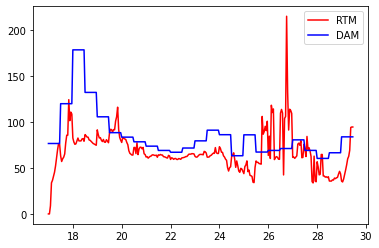

In [ ]:
## feature from Ro

## sort before plot
RTM_price = RTM_price.sort_values('OPR_DT', ascending=True)
DAM_price = DAM_price.sort_values('OPR_DT', ascending=True)
# -7 is a systematic time shift SFO - Greenwich + 1
plt.plot(np.arange(0,300)/24 - 7 + 24, RTM_price.head(300)['MW'], 'r', label = 'RTM')
plt.plot(np.arange(0,300)/24 - 7 + 24, DAM_price.head(300)['MW'], 'b', label = 'DAM')
plt.legend()
plt.show()

In [ ]:
# TODO: Uplift


print(RTM_price)
print(DAM_price)



                   OPR_DT          MW
0     2021-04-01 00:00:00     0.02090
1     2021-04-01 00:05:00     0.02085
2     2021-04-01 00:10:00     8.83622
3     2021-04-01 00:15:00    33.83907
4     2021-04-01 00:20:00    36.56618
...                   ...         ...
28795 2021-07-09 23:35:00   560.36212
28796 2021-07-09 23:40:00   455.08539
28797 2021-07-09 23:45:00   321.36240
28798 2021-07-09 23:50:00   550.25627
28799 2021-07-09 23:55:00  1330.36240

[28800 rows x 2 columns]
                   OPR_DT         MW
0     2021-04-01 00:00:00   76.59346
1     2021-04-01 00:05:00   76.59346
2     2021-04-01 00:10:00   76.59346
3     2021-04-01 00:15:00   76.59346
4     2021-04-01 00:20:00   76.59346
...                   ...        ...
28795 2021-07-09 23:35:00  168.94492
28796 2021-07-09 23:40:00  168.94492
28797 2021-07-09 23:45:00  168.94492
28798 2021-07-09 23:50:00  168.94492
28799 2021-07-09 23:55:00  168.94492

[28800 rows x 2 columns]


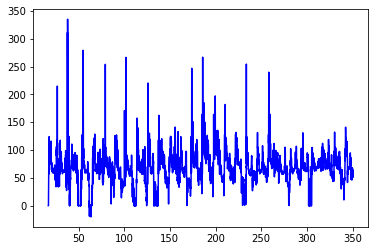

In [ ]:
## Engineering data for prediction
##
## Prepare train and test sets


# prepare the dataset

# we will add for N days 
# - DAM information (legal), (time tick +/1 two intervals)
# - split date-time separately in month vs day vs 
# - weekday vs weekend
# - hours (nominal)
# - RTM information (up to now) N days * 24 hours * 12 timestamps

X = RTM_price.copy()

# always predict the difference once you have a reasonable fit
X['MW'] =  X['MW'] #- DAM_price['MW']
time_steps = 8000

# plot to understand the data
plt.plot(np.arange(0,time_steps)/24 - 7 + 24, X.head(time_steps)['MW'], 'b', label = 'RTM-DAM')
plt.show()

-226.80054
-0.1262845 212.19514639999971
-226.80054 2342.15825


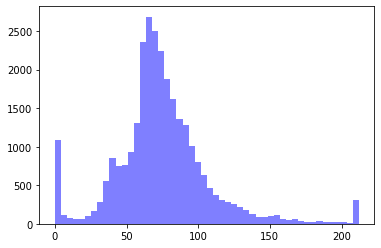

In [ ]:
## filter sample for outliers
print(np.min(X['MW']))

## we do not remove outliers, instead we change peaks to quantile values
q_low = X['MW'].quantile(0.01)
q_hi  = X['MW'].quantile(0.99)

print(q_low, q_hi)
print(np.min(X['MW']), np.max(X['MW']))

## substitute min-max values with quantiles
X.loc[X['MW'] > q_hi, 'MW'] = q_hi
X.loc[X['MW'] < q_low, 'MW'] = q_low


## or just remove them
## X = X.drop(X[X['MW'] < q_low].index)
## X = X.drop(X[X['MW'] < q_hi].index)

# the histogram of the data
num_bins = 50
n, bins, patches = plt.hist(X['MW'], num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [ ]:
print(X['MW'].quantile(0.9995))
print(X['MW'].quantile(0.99999))



212.19514639999971
212.19514639999971


In [ ]:
## Adding basic date-time features
## not in a separate function to simplify the demo
X['month'] = X['OPR_DT'].dt.month
X['hour'] = X['OPR_DT'].dt.hour
X['dayofweek'] = X['OPR_DT'].dt.dayofweek
X['month'] = X['OPR_DT'].dt.month
X['weekday'] = X['OPR_DT'].dt.weekday


print(X)

                   OPR_DT          MW  month  hour  dayofweek  weekday
0     2021-04-01 00:00:00    0.020900      4     0          3        3
1     2021-04-01 00:05:00    0.020850      4     0          3        3
2     2021-04-01 00:10:00    8.836220      4     0          3        3
3     2021-04-01 00:15:00   33.839070      4     0          3        3
4     2021-04-01 00:20:00   36.566180      4     0          3        3
...                   ...         ...    ...   ...        ...      ...
28795 2021-07-09 23:35:00  212.195146      7    23          4        4
28796 2021-07-09 23:40:00  212.195146      7    23          4        4
28797 2021-07-09 23:45:00  212.195146      7    23          4        4
28798 2021-07-09 23:50:00  212.195146      7    23          4        4
28799 2021-07-09 23:55:00  212.195146      7    23          4        4

[28800 rows x 6 columns]


In [ ]:
## Add past features: LAGS
## lag_t = t timestamps back
## hour = 12
## day = 288
## week = 2016

## TODO: convert to lambda expression, cycle for illustrative power
lag_week = 2016
lag_day = 288
lag_hour = 12
lag_5min = 1

## with the RTM market we are not allowed to take use at least today's values 
## but probably 24 h in front (need to clarify when the prices are announced)
## 
## Anyway for real-time one better to use RL/MDP setup
## 

offset = lag_hour

## Fill in past values for RTM market
for i in range(3*lag_5min+lag_hour, 2*lag_day):
  X['lag_' + str(i)] = X['MW'].shift(i)
  X['lag_RTM_' + str(i)] = RTM_price['MW'].shift(i)

## Fill in values for DAM
## I would say that what make sense -- is the price for now, plus/minus 15 minutes
for i in [0, 3, -3]:
  X['lag_DAM_'+str(i)] = DAM_price['MW'].shift(i)

## Add expanding window averages
#data['expanding_mean'] = data['Count'].expanding(2).mean()
#data = data[['Datetime','Count', 'expanding_mean']]
#data.head(10)
# https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/

X = X.drop(['OPR_DT'], axis=1)

print(X)

               MW  month  hour  dayofweek  weekday     lag_15  lag_RTM_15  \
0        0.020900      4     0          3        3        NaN         NaN   
1        0.020850      4     0          3        3        NaN         NaN   
2        8.836220      4     0          3        3        NaN         NaN   
3       33.839070      4     0          3        3        NaN         NaN   
4       36.566180      4     0          3        3        NaN         NaN   
...           ...    ...   ...        ...      ...        ...         ...   
28795  212.195146      7    23          4        4  167.60476   167.60476   
28796  212.195146      7    23          4        4  180.82472   180.82472   
28797  212.195146      7    23          4        4  180.98219   180.98219   
28798  212.195146      7    23          4        4  173.61132   173.61132   
28799  212.195146      7    23          4        4  167.93316   167.93316   

          lag_16  lag_RTM_16     lag_17  ...  lag_RTM_572   lag_573  \
0   

In [ ]:
# ML can not work with datetime format, drop it off
X = X.dropna(axis='rows')

print(X)

               MW  month  hour  dayofweek  weekday     lag_15  lag_RTM_15  \
575     34.935200      4    23          4        4   28.05858    28.05858   
576     50.223840      4     0          5        5   34.08408    34.08408   
577     50.223840      4     0          5        5   33.69686    33.69686   
578     50.223840      4     0          5        5   31.78468    31.78468   
579     50.223840      4     0          5        5   18.75553    18.75553   
...           ...    ...   ...        ...      ...        ...         ...   
28792  212.195146      7    23          4        4  190.00240   190.00240   
28793  212.195146      7    23          4        4  190.00240   190.00240   
28794  212.195146      7    23          4        4  166.00000   166.00000   
28795  212.195146      7    23          4        4  167.60476   167.60476   
28796  212.195146      7    23          4        4  180.82472   180.82472   

          lag_16  lag_RTM_16     lag_17  ...  lag_RTM_572   lag_573  \
575 

In [ ]:
# We are not interesting in small prices, only in the large ones -- drop rows that stand for small prices
q_med = X['MW'].quantile(0.5)
X = X[X['MW'] >= q_med]
print(q_med)

print(X)

71.7444
               MW  month  hour  dayofweek  weekday     lag_15  lag_RTM_15  \
597     81.482400      4     1          5        5   47.41760    47.41760   
598     81.482400      4     1          5        5   52.65520    52.65520   
599     81.482400      4     1          5        5   60.66000    60.66000   
600     81.482400      4     2          5        5   68.58000    68.58000   
601     81.482400      4     2          5        5   70.01760    70.01760   
...           ...    ...   ...        ...      ...        ...         ...   
28792  212.195146      7    23          4        4  190.00240   190.00240   
28793  212.195146      7    23          4        4  190.00240   190.00240   
28794  212.195146      7    23          4        4  166.00000   166.00000   
28795  212.195146      7    23          4        4  167.60476   167.60476   
28796  212.195146      7    23          4        4  180.82472   180.82472   

          lag_16  lag_RTM_16     lag_17  ...  lag_RTM_572   lag_573

In [ ]:
## setup labels
Y = X['MW']
X.drop(['MW'], axis=1, inplace=True)
## Remove all rows with NANs instead of filling them to prevent bias
X = X.dropna(axis='rows')

print(X)

## Split train, validation and test
train_size = int(len(X)*.6)
val_size =  int(len(X)*.2)
X_train = X.head(n=train_size)
Y_train = Y.head(n=train_size)

X_val = X.iloc[train_size:train_size + val_size, :]
Y_val = Y.iloc[train_size:train_size + val_size]

X_test = X.tail(n=len(X) - train_size - val_size)
Y_test = Y.tail(n=len(Y) - train_size - val_size)

       month  hour  dayofweek  weekday     lag_15  lag_RTM_15     lag_16  \
597        4     1          5        5   47.41760    47.41760   49.28328   
598        4     1          5        5   52.65520    52.65520   47.41760   
599        4     1          5        5   60.66000    60.66000   52.65520   
600        4     2          5        5   68.58000    68.58000   60.66000   
601        4     2          5        5   70.01760    70.01760   68.58000   
...      ...   ...        ...      ...        ...         ...        ...   
28792      7    23          4        4  190.00240   190.00240  200.89632   
28793      7    23          4        4  190.00240   190.00240  190.00240   
28794      7    23          4        4  166.00000   166.00000  190.00240   
28795      7    23          4        4  167.60476   167.60476  166.00000   
28796      7    23          4        4  180.82472   180.82472  167.60476   

       lag_RTM_16     lag_17  lag_RTM_17  ...  lag_RTM_572   lag_573  \
597      49.283

In [ ]:
print(X_val, Y_val)

       month  hour  dayofweek  weekday    lag_15  lag_RTM_15    lag_16  \
21792      6    16          1        1  71.26170    71.26170  74.33156   
21793      6    16          1        1  71.20441    71.20441  71.26170   
21794      6    16          1        1  70.88853    70.88853  71.20441   
21814      6    17          1        1  61.21080    61.21080  59.44738   
21815      6    17          1        1  58.91406    58.91406  61.21080   
...      ...   ...        ...      ...       ...         ...       ...   
25338      6    23          6        6  85.46594    85.46594  84.79780   
25339      6    23          6        6  86.73479    86.73479  85.46594   
25340      6    23          6        6  87.99163    87.99163  86.73479   
25341      6    23          6        6  88.53074    88.53074  87.99163   
25342      6    23          6        6  90.14240    90.14240  88.53074   

       lag_RTM_16    lag_17  lag_RTM_17  ...  lag_RTM_572   lag_573  \
21792    74.33156  73.86860    73.86860 

In [ ]:
## XGB regressor

# grid size for search 
## n_estimators x max_depth x learning rate

estimators = [20, 40, 60]
rates = [0.1, 0.2, 0.3, 0.4]
depths = [5, 6, 7, 8]

#pool = [*product(range(len(estimators)), range(len(depths)), range(len(rates)))]
pool = [*product(estimators, depths, rates)]

#20, 5, 0.3 
random_indices = random.sample(pool, 10)

val_acc = {}
for edr in random_indices:
  xgbr = xgb.XGBRegressor(booster='gbtree', max_depth=edr[1], objective='reg:squarederror', n_estimators=edr[0],learning_rate=edr[2], criterion='squared_error', verbosity=1) #, 
  xgbr.fit(X_train, Y_train)
  score = xgbr.score(X_train, Y_train)  
  print('score ', score, ' learning_rate', edr)
  
  mae_train  = mean_absolute_error(xgbr.predict(X_train), Y_train)
  mae_val = mean_absolute_error(xgbr.predict(X_val), Y_val)
  mae_test = mean_absolute_error(xgbr.predict(X_test), Y_test)
  print('mae train: ', mae_train, 'mae test: ', mae_test, 'mae_val', mae_val)

  val_acc[edr] = mean_absolute_error(xgbr.predict(X_val), Y_val)

print(val_acc)
#mse = mean_squared_error(Y_test, Y_pred)
#print(xgbr)

## Add Thompson sampling here 

score  0.8993123375706074  learning_rate (20, 7, 0.3)
mae train:  6.515920119265684 mae test:  15.683817050076307 mae_val 13.845715635362636
score  0.9456009151269854  learning_rate (40, 6, 0.4)
mae train:  4.8691121422217725 mae test:  16.432414875079974 mae_val 14.501205449528534
score  0.8539932707137496  learning_rate (20, 6, 0.3)
mae train:  7.733460404575951 mae test:  15.102529828957028 mae_val 13.187562530529757
score  0.8968760450163594  learning_rate (40, 6, 0.2)
mae train:  6.609925032632605 mae test:  15.27558179313365 mae_val 13.241659091517505
score  0.5468077515433474  learning_rate (20, 7, 0.1)
mae train:  12.922806181252566 mae test:  18.73148405557263 mae_val 16.139376191330186
score  0.9906384547443933  learning_rate (60, 7, 0.4)
mae train:  2.055671427723657 mae test:  15.717599478473831 mae_val 13.413368685633282
score  0.9776344480115611  learning_rate (40, 7, 0.4)
mae train:  3.185836025939567 mae test:  15.651188822191314 mae_val 13.415251826693616
score  0.8893

In [ ]:
## find optimal hyperparameters 
edr = {key: value for key, value in val_acc.items() if value == min(val_acc.values())}

edr = list(edr)[0]

## retrain again and check the gain compared to DAM
xgbr = xgb.XGBRegressor(booster='gbtree', max_depth=edr[1], objective='reg:squarederror', n_estimators=edr[0],learning_rate=edr[2], criterion='absolute_error', verbosity=1) #, 
xgbr.fit(X_train, Y_train)
  
mae_train  = mean_absolute_error(xgbr.predict(X_train), Y_train)
mae_val = mean_absolute_error(xgbr.predict(X_val), Y_val)
mae_test = mean_absolute_error(xgbr.predict(X_test), Y_test)
mae_overall = mean_absolute_error(xgbr.predict(X), Y)

print("train", mae_train, "test", mae_test, "val", mae_val, "overall", mae_overall)

print("RTM-DAM mae", np.mean(np.abs(RTM_price['MW'] - DAM_price['MW'])))

train 7.733460404575951 test 15.102529828957028 val 13.187562530529757 overall 10.298435189103584
RTM-DAM mae 24.86086229652778


In [ ]:
#x_ax = range(2000)
#plt.plot(x_ax, Y_test[-2001:-1], 'r', label="RTM")
#plt.plot(x_ax, DAM_price['MW'][-3001:-1], 'g', label="DAM")
#plt.plot(x_ax, xgbr.predict(X_test)[-2001:-1], 'b', label="Prediction") #normalize with DAM data
#plt.title("Test, DAM and predicted data")
#plt.legend()
#plt.show()

In [ ]:
print("Learning Approx:", mae_overall)

print("RTM-DAM mae", np.mean(np.abs(RTM_price['MW'] - DAM_price['MW'])))

Learning Approx: 10.298435189103584
RTM-DAM mae 24.86086229652778


In [ ]:
## one more classifier just for test
forest = RandomForestRegressor(n_estimators=20, max_depth=10, criterion='absolute_error')
forest.fit(X_train, Y_train)
Y_pred = forest.predict(X_test)

Y_pred = xgbr.predict(X_test)
mae_test = mean_absolute_error(Y_test, Y_pred)
mae_val = mean_absolute_error(forest.predict(X_val), Y_val)
mae_train = mean_absolute_error(forest.predict(X_train), Y_train)

print("MAE test/validation/train: %.2f %.2f %.2f " % mae_train, mae_val, mae_train)

KeyboardInterrupt: ignored

In [ ]:
## K-fold cross validation

score = xgbr.score(X_train, Y_train)  
print("Training score: ", score)

## Cross validation, works slowly over large datasets
#scores = cross_val_score(xgbr, X_train, Y_train, cv=10)
#print("Mean cross-validation score: %.2f" % scores.mean())

## Faster Alternative to cross validation
kfold = KFold(n_splits=5, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, Y_train, cv=kfold)
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())